In [1162]:
from umap import UMAP
import numpy as np
from sklearn.neighbors import KernelDensity, radius_neighbors_graph, NearestNeighbors
from scipy.sparse.csgraph import connected_components
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

In [1163]:
# import data
path = r'C:\Users\ncwbr\Desktop\data600.npy'
raw_data = np.load(path, allow_pickle=True)
print(raw_data.shape)

(10000, 600)


In [1164]:
# Random Project with Gaussian
grp = GaussianRandomProjection(n_components=300, random_state=2427348)
data = grp.fit_transform(raw_data)
print(data.shape)

(10000, 300)


In [1165]:
# PCA
pca = PCA(n_components=50, random_state=2427348)
data = pca.fit_transform(data)
print(data.shape)

(10000, 50)


In [1166]:
# UMAP
umap = UMAP(
    n_components=3,    
    n_neighbors=15,
    min_dist=0.1,
    metric='euclidean',
    random_state=2427348
)
data1 = umap.fit_transform(data)
print(data1.shape)
print(data1[: 10])

C:\Users\ncwbr\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



(10000, 3)
[[ 7.420192    1.805293   11.498418  ]
 [ 4.163731    1.3188154  12.492722  ]
 [ 5.5375385   1.5863177  10.9244375 ]
 [ 3.7132912   2.594118   12.182661  ]
 [ 4.2825613   3.1843634  10.906403  ]
 [ 5.8843617  -0.4032617  10.570928  ]
 [ 7.35803     0.81162447 11.187323  ]
 [ 6.5823736   2.0759861  12.4933815 ]
 [ 6.1289496   1.8457751  11.516758  ]
 [ 3.0151978   2.7538416  12.519617  ]]


In [1167]:
# Kernal Density Estimator with dimension d = 3
n, d = data1.shape
sigma = np.std(data1, axis=0, ddof=1)  
factor = (4.0 / (d + 2)) ** (1.0 / (d + 4)) * n ** (-1.0 / (d + 4))
h = factor * sigma           
bandwidth = np.mean(h)
alpha = 1.3
kde = KernelDensity(kernel='gaussian', bandwidth=alpha * bandwidth)
kde.fit(data1)
log_dens = kde.score_samples(data1)

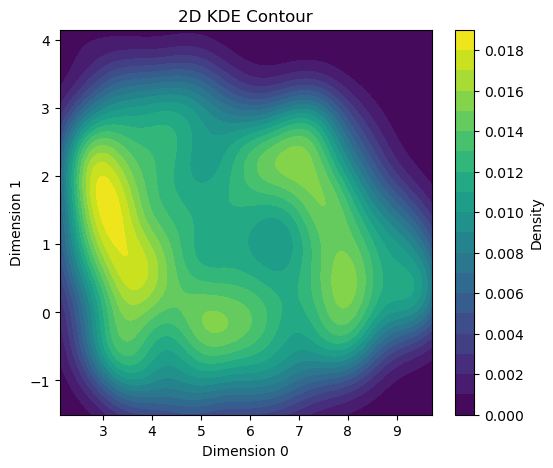

In [1168]:
# Plot 2D KDE Contours
x = np.linspace(data1[:,0].min(), data1[:,0].max(), 200)
y = np.linspace(data1[:,1].min(), data1[:,1].max(), 200)
xx, yy = np.meshgrid(x, y)
grid2 = np.vstack([xx.ravel(), yy.ravel()]).T

mean_vals = data1.mean(axis=0)
grid3 = np.zeros((grid2.shape[0], 3))
grid3[:,0:2] = grid2
grid3[:,2:] = mean_vals[2:]

log_dens2 = kde.score_samples(grid3)
dens2 = np.exp(log_dens2).reshape(xx.shape)

plt.figure(figsize=(6,5))
cs = plt.contourf(xx, yy, dens2, levels=20)
plt.colorbar(cs, label="Density")
plt.xlabel("Dimension 0")
plt.ylabel("Dimension 1")
plt.title("2D KDE Contour")
plt.show()

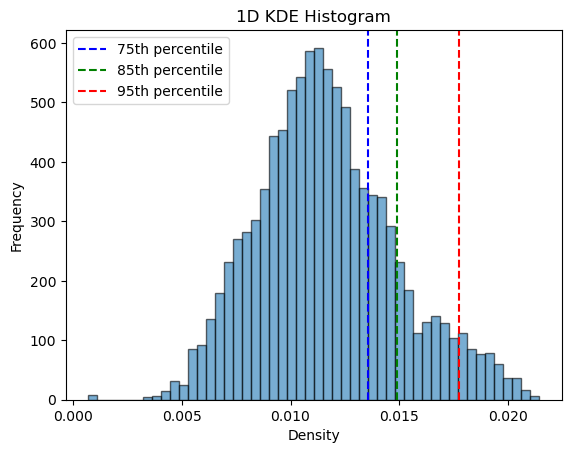

In [1169]:
# Plot Histogram
dens = np.exp(log_dens)
plt.hist(dens, bins=50, edgecolor='k', alpha=0.6)
plt.axvline(np.percentile(dens, 75), color='b', linestyle='--', label='75th percentile')
plt.axvline(np.percentile(dens, 85), color='g', linestyle='--', label='85th percentile')
plt.axvline(np.percentile(dens, 95), color='r', linestyle='--', label='95th percentile')
plt.xlabel("Density")
plt.ylabel("Frequency")
plt.legend()
plt.title("1D KDE Histogram")
plt.show()

In [1170]:
# Clustering Method 1 Level Set Clustering + Nearest Neighbor
def levelset_clustering(data, p, dens, bandwidth):
    lambda_cut = np.percentile(dens, p)
    mask_core = dens >= lambda_cut
    core_idx = np.where(mask_core)[0]
    data_core = data1[core_idx]
    
    r = bandwidth * 1.5
    A = radius_neighbors_graph(data_core, radius=r, mode='connectivity', include_self=True)
    n_cps, labels_core = connected_components(csgraph=A, directed=False)
    
    labels_1 = -1 * np.ones(n, dtype=int)
    labels_1[core_idx] = labels_core
    
    low_idx = np.where(~mask_core)[0]
    labels_1[low_idx] = np.arange(n_cps, n_cps + low_idx.size)
    data_low = data1[low_idx]
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(data_core)
    distances, indices = nbrs.kneighbors(data_low)
    nearest_core_idx = indices.flatten()
    labels_low = labels_core[nearest_core_idx]
    labels_1[low_idx] = labels_low
    score = silhouette_score(data1, labels_1)
    return score, labels_1

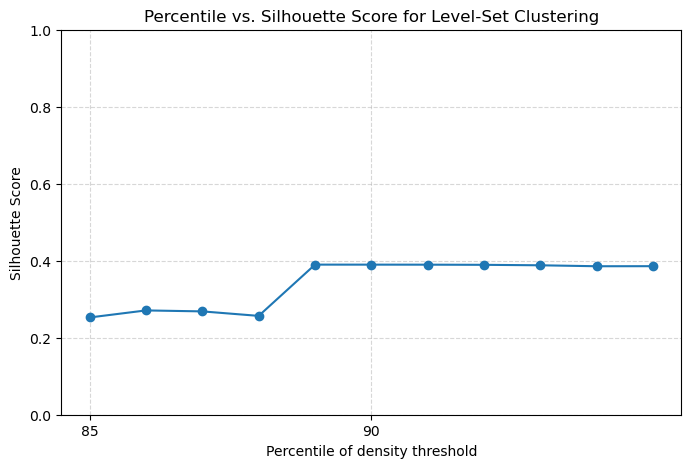

In [1171]:
percentiles = list(range(85, 96))
sil_scores = []

for p in percentiles:
    score = levelset_clustering(data1, p, dens, bandwidth)[0]
    sil_scores.append(score)

percentiles = np.array(percentiles)
sil_scores = np.array(sil_scores)
plt.figure(figsize=(8, 5))
plt.plot(percentiles, sil_scores, marker='o', linestyle='-')
plt.xticks(np.arange(85, 95, 5))
plt.xlabel("Percentile of density threshold")
plt.ylabel("Silhouette Score")
plt.title("Percentile vs. Silhouette Score for Level-Set Clustering")
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 1)
plt.show()

In [1172]:
# Print the clustering result
score, labels_1 = levelset_clustering(data1, 89, dens, bandwidth)
unique, counts = np.unique(labels_1, return_counts=True)
for lab, cnt in zip(unique, counts):
    print(f" Cluster {lab+1}: {cnt}")
print(f"Silhouette Score: {score}")

 Cluster 1: 4626
 Cluster 2: 5374
Silhouette Score: 0.3898702561855316


C:\Users\ncwbr\AppData\Local\Temp\ipykernel_14772\4109784582.py:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



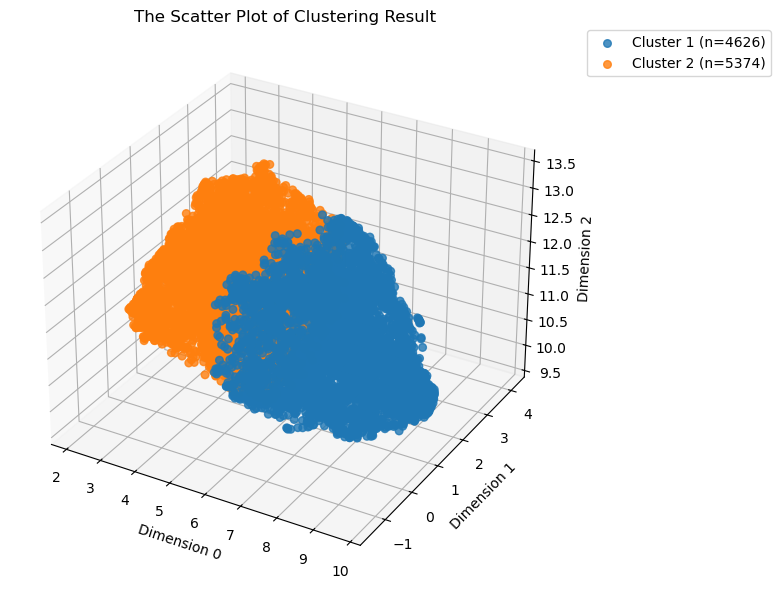

In [1173]:
unique_labels, counts = np.unique(labels_1, return_counts=True)

cmap = cm.get_cmap("tab10")
colors = {lab: cmap(i % cmap.N) for i, lab in enumerate(ordered_labels)}

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for lab in ordered_labels:
    mask = (labels_1 == lab)
    ax.scatter(
        data1[mask, 0], data1[mask, 1], data1[mask, 2],
        c=[colors[lab]], marker="o", s=30, alpha=0.8,
        label=f"Cluster {lab+1} (n={counts[unique_labels==lab][0]})"
    )

ax.set_xlabel("Dimension 0")
ax.set_ylabel("Dimension 1")
ax.set_zlabel("Dimension 2")
ax.set_title(f"The Scatter Plot of Clustering Result")

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

plt.tight_layout()
plt.show()

In [1174]:
with open("alg1_out.txt", "w") as fout:
    for lab in labels:
        fout.write(f"{lab+1}\n")

In [1175]:
def estimate_k_eigengap(data, k0=10, m=50):
    n_samples, _ = data.shape
    nbrs = NearestNeighbors(n_neighbors=k0+1, algorithm='auto').fit(data)
    distances, indices = nbrs.kneighbors(data)
    sigma = np.median(distances[:, k0])
    rows, cols, vals = [], [], []
    
    for i in range(n_samples):
        for j_idx in range(1, k0+1):
            j = indices[i, j_idx]
            dist_ij = distances[i, j_idx]
            w = np.exp(- (dist_ij**2) / (2 * sigma**2))
            rows.append(i)
            cols.append(j)
            vals.append(w)

    W = csr_matrix((vals, (rows, cols)), shape=(n_samples, n_samples))
    W = W.maximum(W.T)  
    d = np.array(W.sum(axis=1)).flatten() 
    inv_sqrt_d = np.zeros_like(d)
    mask = (d > 0)
    inv_sqrt_d[mask] = 1.0 / np.sqrt(d[mask])
    W_norm = W.multiply(inv_sqrt_d[:, np.newaxis])
    W_norm = W_norm.multiply(inv_sqrt_d[np.newaxis, :])
    eigvals_W, _ = eigsh(W_norm, k=m, which='LA')
    eigvals_W = np.sort(eigvals_W)      
    eigvals_W_desc = eigvals_W[::-1]   
    eigvals_L = 1.0 - eigvals_W_desc   
    eigvals_L = np.sort(eigvals_L)      
    gaps_all = np.diff(eigvals_L)       
    subgaps = gaps_all[1:]              
    idx = np.argmax(subgaps)            
    k_est = idx + 2                      

    return k_est, eigvals_L, subgaps

In [1176]:
data = grp.fit_transform(raw_data)
data = pca.fit_transform(data)
umap = UMAP(
    n_components=20,    
    n_neighbors=20,
    min_dist=0.1,
    metric='euclidean',
    random_state=2427348
)
data2 = umap.fit_transform(data)

C:\Users\ncwbr\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



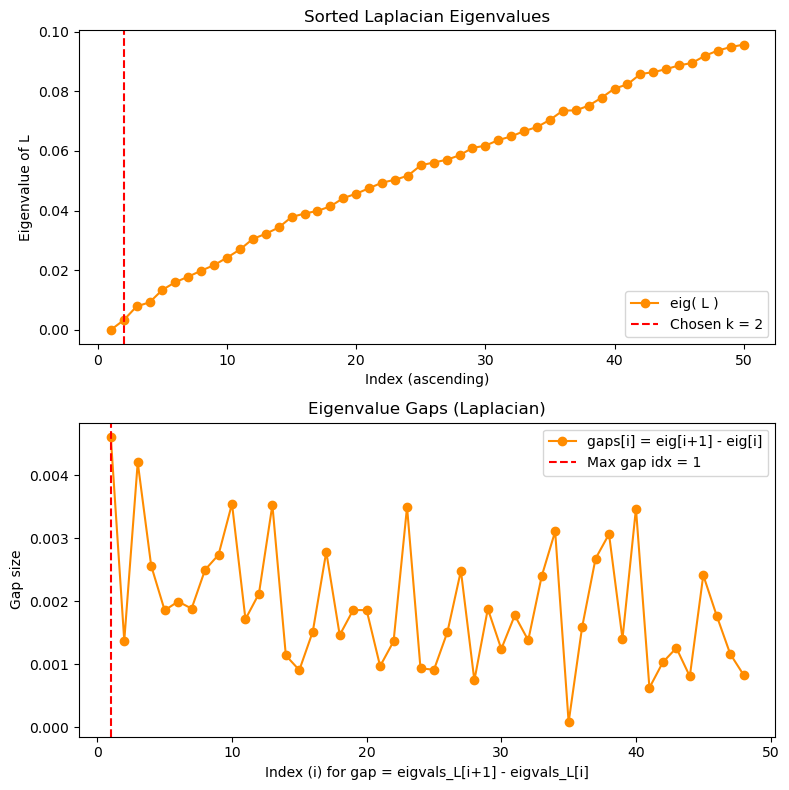

Estimated number of clusters (k): 2


In [1177]:
k_est, eigvals_L, gaps_all = estimate_k_eigengap(data2, k0=30, m=50)
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

axes[0].plot(range(1, len(eigvals_L) + 1), eigvals_L, marker='o', linestyle='-',
             color='darkorange', label='eig( L )')
axes[0].axvline(k_est, color='red', linestyle='--', label=f'Chosen k = {k_est}')
axes[0].set_xlabel('Index (ascending)')
axes[0].set_ylabel('Eigenvalue of L')
axes[0].set_title('Sorted Laplacian Eigenvalues')
axes[0].legend()

axes[1].plot(range(1, len(gaps_all) + 1), gaps_all, marker='o', linestyle='-',
             color='darkorange', label='gaps[i] = eig[i+1] - eig[i]')
axes[1].axvline(k_est - 1, color='red', linestyle='--', label=f'Max gap idx = {k_est - 1}')
axes[1].set_xlabel('Index (i) for gap = eigvals_L[i+1] - eigvals_L[i]')
axes[1].set_ylabel('Gap size')
axes[1].set_title('Eigenvalue Gaps (Laplacian)')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Estimated number of clusters (k): {k_est}")

In [1178]:
# Clustering Method 2 Spectral Clustering
k = k_est
sc = SpectralClustering(
    n_clusters=k,
    affinity='nearest_neighbors',
    assign_labels='kmeans',
    random_state=2427348
)
labels_2 = sc.fit_predict(data2)
unique, counts = np.unique(labels_2, return_counts=True)
for lab, cnt in zip(unique, counts):
    print(f" Cluster {lab+1}: {cnt}")
score = silhouette_score(data2, labels_2)
print(f"Silhouette Score: {score}")

 Cluster 1: 6099
 Cluster 2: 3901
Silhouette Score: 0.3704628050327301


C:\Users\ncwbr\AppData\Local\Temp\ipykernel_14772\1866588186.py:9: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



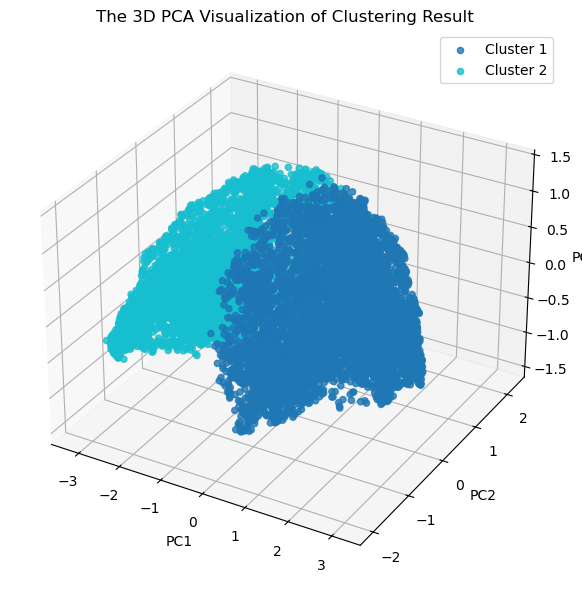

In [1179]:
pca = PCA(n_components=3, random_state=42)
data2_3d = pca.fit_transform(data2)   # data2_3d.shape = (n_samples, 3)


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

unique_labels = np.unique(labels_2)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

for lab in unique_labels:
    mask = (labels_2 == lab)
    ax.scatter(
        data2_3d[mask, 0],
        data2_3d[mask, 1],
        data2_3d[mask, 2],
        label=f'Cluster {lab+1}',
        s=20,
        alpha=0.8,
        color=colors(lab)
    )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(loc='best', fontsize=10)
ax.set_title(f'The 3D PCA Visualization of Clustering Result')
plt.tight_layout()
plt.show()

In [1180]:
with open("alg2_out.txt", "w") as fout:
    for lab in labels_1:
        fout.write(f"{lab+1}\n")